# Quinine: Main Paper Figure 2

In [1]:
# Some magic functions
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pathlib import Path

root = Path("../../")
molecule = "quinine"

# Path to the 2DJ dataset
# Under this directory, NMR-EsPy expects a ser file, an acqus file, and an acqu2s file to exist
data_dir = root / "data" / molecule / "1"

# Directory which results will be output to
output_dir = root / "code" / molecule / "output"
output_dir.mkdir(exist_ok=True, parents=True)

## Importing and pre-processing the data

In the cell below, the following is carried out (see the `else` block):

1. The 2DJ dataset is loaded into NMR-EsPy using `new_bruker`
2. The dataset is phased in the direct-dimension
3. Baseline correction is applied to the direct-dimension signals

It is possible to store estimator objects using Python's "pickling" protocol. These can be reloaded at a future time.
This cell uses a control statement to load a pre-saved estimator object if one already exists, and to create a new one and subsequently save it if one den't exist yet.

In [4]:
import nmrespy as ne

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_dir)
    estimator.phase_data(p0=1.803, p1=-6.239)
    estimator.baseline_correction()
    estimator.to_pickle(estimator_path)

## Estimation

The try-except block checks whether the estimator already contains results (these are stored in the `_results` attribute). If there are results present, the estimation routine is skipped to save time. If there are no results, a `ValueError` is raised. If this is caught, the estimation routine is run.

The list of 2-tuples indicating the regions to estimate is provided, along with additional additional parameters, contained in the `estimate_kwargs` dictionary:

* `noise_region` - Defines a region deviod of signals which is used to estimate the noise variance. This is made use of in the frequency filtration.
* `region_unit` - Defines the unit the the regions are given (`"ppm"` or `"hz"` are accepted).
* `check_neg_amps_every` - After a multiple of this number of iterations has been performed, the parameter set is checked for the presence of negative amplitudes. If these are found, they are removed from the parameter set, and the optimisation is re-started.
* `max_iterations` - The largest permitted number of iterations before the routine is terminated.

Note that it is a good idea to save the estimator after the completion of each call to `estimate` to ensure data loss is not incurred. For example, if multiple regions have been estimated, and an error subsequently arises, the program will crash and all the results will cleaned up from the computer's RAM!

### Providing a Model Order Guess

In some cases, it can be beneficial to provided a hard-coded estimate of the number of signals that the region of interest comprises. This is most commonly necessary when the automated model order selection routine, which makes use of the Minimum Description Length criterion (MDL), outputs an underestimate for regions that are highly crowded. The model order can be hard-coded by setting the `initial_guess` kwarg to some integer value. This has been applied to one region in this example: 2 - 1.7 ppm, where an initial guess of 36 has been provided (cf. 33 which is generated by the MDL). This was done to improve the fit the multiplet at 1.8ppm; only four individual signals are fit to this without hard-coding the model order, which can be seen by commenting out the line:

`initial_guesses[5] = 36`

In [5]:
import numpy as np
np.random.seed(0)

try:
    estimator.get_results()
except ValueError:
    regions = [
        (5.8, 5.55),
        (5., 4.85),
        (3.75, 3.63),
        (3.17, 3.06),
        (2.8, 2.6),
        (2.0, 1.7),
        (1.64, 1.52),
        (1.52, 1.40),
    ]
    estimate_kwargs = dict(
        noise_region=(10.2, 10.0),
        region_unit="ppm",
        check_neg_amps_every=100,
        max_iterations=500,
    )
    initial_guesses = len(regions) * [None]
    initial_guesses[1] = 17
    initial_guesses[5] = 36 
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess, 
            **estimate_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌──────────────────────────────────────┐
│ESTIMATING REGION: 5.8 - 5.55 ppm (F2)│
└──────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 18
--> Pencil parameters: 64, 75
--> Enhanced Block Hankel matrix constructed:
	Size: 4800 x 4940
	Memory: 0.3533GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 8 secs, 238 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.723091     │ 1.92945      │ 1      

## Plotting the Result

The following cell provides a function which generates a figure outlining the estimation result using the estimator's `plot_result` method. A large number of kwargs are provided to adjust the aesthetics of the figure, with a detailed summary [here](https://foroozandehgroup.github.io/NMR-EsPy/references/estimator2dj.html#nmrespy.Estimator2DJ.plot_result).

### Predicting Multiplets

Once the estimation routine is complete, it is possible to group signals in the fit model to form multiplets. The grouping relies on the fact that for a given multiplet, all signals should have the same "central frequency", defined as $f^{(2)} - f^{(1)}$, where $f^{(1)}$ and $f^{(2)}$ are the indirect- and direct-dimension frequencies of a given signal, respectively. To account for error in the experiment and estimation, all signals for which the above criterion is the same within an appropriate threshold are deemed to be in the same multiplet. A default threshold is defined, and accessbile via `estimator.default_multiplet_thold`. However, this can sometimes be too small, and signals which clearly belong to the same multiplet strcture may be deemed to be separate.
Here, the threshold has been set to 1Hz. This is large enough to rsolve all the multiplet cleanly, but small enough to separate the multiplet structure at ca. 4.9ppm from the intense broad singlet corresponding to water.

In [52]:
import copy
import matplotlib.pyplot as plt


MP_THOLD = 0.92
DEFAULT_PLOT_KWARGS= dict(
    region_unit="ppm",
    multiplet_thold=MP_THOLD,
    multiplet_lw=0.8,
    marker_size=15.0,
    figsize=(8.0, 4.0),
    axes_left=0.1,
    axes_right=0.99,
    axes_bottom=0.11,
    axes_top=0.98,
    contour_base=4.0e3,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    lb=0.5,
)

def plot_result(
    est,
    **kwargs,
):
    all_kwargs = copy.deepcopy(DEFAULT_PLOT_KWARGS)
    for key, value in kwargs.items():
        all_kwargs[key] = value
        
    fig, axs = est.plot_result(**all_kwargs)
    return fig, axs

regions: [(0, (5.800401951654557, 5.550237405000879)), (1, (5.0000600256444505, 4.849592051088917)), (2, (3.750160408784378, 3.6301552757032773)), (3, (3.1704433043618327, 3.059669335363893)), (4, (2.8002736246270543, 2.5999573640224485)), (5, (1.9999316986169486, 1.699918865914198)), (6, (1.6399162993736485, 1.5199111662925477)), (7, (1.5199111662925477, 1.399906033211449))]
idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
merge_indices: [[0], [1], [2], [3], [4], [5], [6, 7]]
merge_regions: [(5.800401951654557, 5.550237405000879), (5.0000600256444505, 4.849592051088917), (3.750160408784378, 3.6301552757032773), (3.1704433043618327, 3.059669335363893), (2.8002736246270543, 2.5999573640224485), (1.9999316986169486, 1.699918865914198), (1.6399162993736485, 1.399906033211449)]
plot_data: [[(array([-17.54096993,  -9.96188381,  -7.161325  ,  -0.38232314,
         0.40703885,   7.16660565,   9.96544604,  17.53574973]), array([5.71200856, 5.72706553, 5.73265379, 5.74615003, 5.74768453,

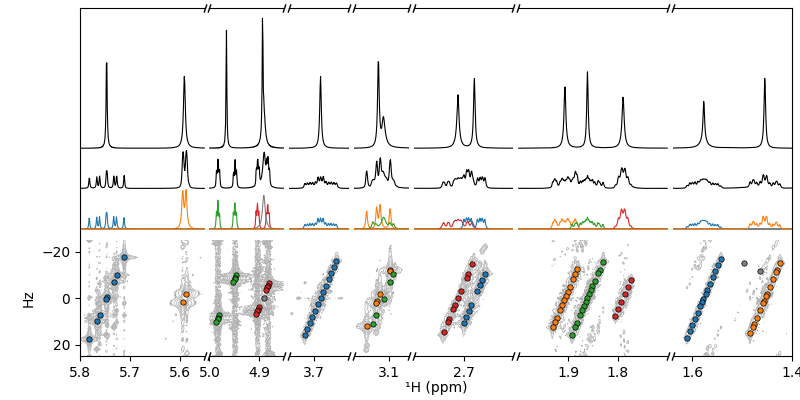

In [53]:
# Define colours for multiplets
COLORS = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[:4]
# Add gray to denote signals that are not related to quinine first-orer multiplets
COLORS.append("#808080")

def get_colors_from_indices(mp_indices):
    return [COLORS[i] for i in mp_indices]
    
full_xaxis_ticks = [
    (0, [5.8, 5.7, 5.6]),
    (2, [3.7]),
    (3, [3.1]),
    (4, [2.7]),
    (5, [1.9, 1.8]),
]
multiplet_colors = get_colors_from_indices(
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 0, 4, 4, 1]
)
_, _ = plot_result(
    estimator,
    xaxis_ticks=full_xaxis_ticks,
    multiplet_colors=multiplet_colors,
)

## Removing the Spurious Signal

Inscpecting the plot above, it can be seen that there are two fit signals which appear to be derived from strong coupling artifacts or noise. These signals and a suspected water signal at ~4.9ppm have been coloured grey, to indicate that they are not related to one of the first-order quinine multiplets.

The two grey signals at ~1.5ppm can be automatically removed from the result, by calling the `predict_multiplets` method, with the `rm_spurious` kwarg set to `True`. After grouping all the signals into multiplets, any grouping with the following criteria are marked for removal from the result:

1. The grouping contains a single signal.
2. The indirect-dimension frequency of the signal has a magnitude which is larger than the threshold set for the multiplet prediction (0.92Hz in this case).

Any groupings that fulfil these criteria are likely to contain a fit signal which is unrelated to the first-order signals in the 2DJ spectrum. The water signal remains since it has an indirect-dimension frequency which is very close to 0Hz.
At the bottom of the following cell, the indirect- and direct-dimension frequencies of the water signal are determined. 

regions: [(0, (5.800401951654557, 5.550237405000879)), (1, (5.0000600256444505, 4.849592051088917)), (2, (3.750160408784378, 3.6301552757032773)), (3, (3.1704433043618327, 3.059669335363893)), (4, (2.8002736246270543, 2.5999573640224485)), (5, (1.9999316986169486, 1.699918865914198)), (6, (1.6399162993736485, 1.5199111662925477)), (7, (1.5199111662925477, 1.399906033211449))]
idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
merge_indices: [[0], [1], [2], [3], [4], [5], [6, 7]]
merge_regions: [(5.800401951654557, 5.550237405000879), (5.0000600256444505, 4.849592051088917), (3.750160408784378, 3.6301552757032773), (3.1704433043618327, 3.059669335363893), (2.8002736246270543, 2.5999573640224485), (1.9999316986169486, 1.699918865914198), (1.6399162993736485, 1.399906033211449)]
plot_data: [[(array([-17.54096993,  -9.96188381,  -7.161325  ,  -0.38232314,
         0.40703885,   7.16660565,   9.96544604,  17.53574973]), array([5.71200856, 5.72706553, 5.73265379, 5.74615003, 5.74768453,

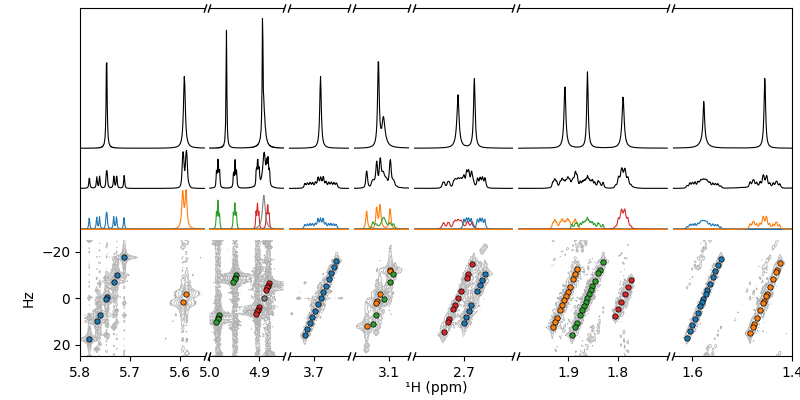

In [54]:
estimator_final = copy.deepcopy(estimator)
estimator_final.predict_multiplets(thold=MP_THOLD, rm_spurious=True);
multiplet_colors = get_colors_from_indices(
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1]
)
_, _ = plot_result(
    estimator_final,
    xaxis_ticks=full_xaxis_ticks,
    multiplet_colors=multiplet_colors,
)

# In the 5-4.85ppm result (index 1), the water signal has the indirect frequency 
# with the smallest magnitude.
# I'll use this information to extract the indirect and direct-dimension
# frequencies of the signal
result1_params = estimator.get_results(indices=[1])[0].get_params(funit="ppm")
water_index = np.argmin(np.abs(result1_params[:, 2]))
water_params = result1_params[water_index]

print(
    "Water location:\nF1: {:.4f} Hz, F2: {:.3f} ppm".format(
        water_params[2],
        water_params[3],
    )
)

regions: [(1, (5.0000600256444505, 4.849592051088917))]
idx: 1
merge_indices: [[1]]
merge_regions: [(5.0000600256444505, 4.849592051088917)]
plot_data: [[(array([-10.10452835,  -8.76040529,  -8.37508524,  -7.02858403,
         7.02572828,   8.37782905,   8.75576532,  10.10370451]), array([4.94530339, 4.94798427, 4.94874156, 4.95139629, 4.97935335,
       4.98198802, 4.98273529, 4.98543652])), (array([-6.65022028, -5.45595606, -4.91647847, -3.72463243,  3.71811039,
        4.91016944,  5.45043425,  6.64417793]), array([4.87950692, 4.88189584, 4.88291324, 4.88529221, 4.90011973,
       4.90249654, 4.90350783, 4.90589268])), (array([0.00332984]), array([4.89018708]))]]


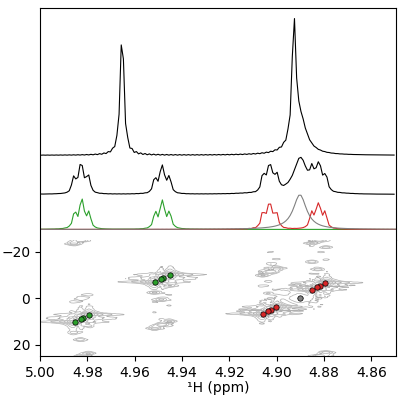

In [55]:
e = copy.deepcopy(estimator_final)
p = copy.deepcopy(e._results[1].params)
res = e.sw()[1] / e.default_pts[1]
p[:, 3] -= 0.25 * res
e._results[1].params = p
fig, axs = plot_result(
    e,
    indices=[1],
    multiplet_colors=get_colors_from_indices([2, 3, 4]),
    figsize=(4.0, 4.0),
    high_resolution_pts=32684,
    contour_base=2.0e4,
    contour_factor=2.5,
)